In [1]:
import imp
from plt_bulk import bulk_disp
import numpy as np
from collections import deque
from matplotlib import pyplot as plt
alat = 14.5533

In [7]:
param = np.zeros(11)
param[0] = 2.0 
param[1] = 2.0 
param[2] = -0.5 
param[3] = -0.15
param[5] = +0.05

param_k = [0.0,0.0, 3.29, 0.57, 0.0, -0.07, 0.19, 0.31, 0.47, 0.0, 0.04]
param_k_noil = param_k[:6] + 5*[0.] 
type(param_k_noil[6:]) ,param_k_noil


(list, [0.0, 0.0, 3.29, 0.57, 0.0, -0.07, 0.0, 0.0, 0.0, 0.0, 0.0])

In [8]:
direct = np.array([[  0.445836 , -0.257404 ,  0.857306],   
                   [ 0.000000  , 0.514807  , 0.857306 ], 
                   [-0.445836  , -0.257404 , 0.857306 ]])

recip = np.array([[ 1.121488, -0.647491,  0.388815],  
                  [ -0.000000,  1.294983, 0.388815],  
                  [ -1.121488, -0.647491,  0.388815]] ) 

In [158]:
inp = {
			 'param':-np.array(param_k), 
			 'S':3.0/2.0}
k = np.array([1./3.,-1./3.,0.0])
zs = np.array([0.3333333,0.333333,0.3333333])
gk0 = [bulk_disp(*(c*k+3*zs), branch=0,**inp) for c in np.linspace(0.9,1.1,num=120)] 
gk1 = [bulk_disp(*(c*k+3*zs), branch=1,**inp) for c in np.linspace(0.9,1.1,num=120)]
K = k.dot(recip)
h1 = np.array([1,-1,0]).dot(direct)
a_hex = np.sqrt((h1.dot(h1)))
sk = np.sqrt(K.dot(K))/a_hex
gkascissa = [c*sk for c in np.linspace(0.9,1.1,num=120)]


In [140]:
zs.dot(recip).dot(direct[0]+direct[1]+direct[2])

0.9999998971699365

In [ ]:
type(dict.update(inp,{'branch':0}))

NoneType

In [ ]:
K = k.dot(recip)  
m1 = np.sqrt(K.dot(K))
Kp = recip[0] -recip[2]
m2 = np.sqrt(Kp.dot(Kp))
Kp/3.0 

array([0.74765867, 0.        , 0.        ])

In [ ]:
np.sqrt(direct[0].dot(direct[0]))

1.0000000678739978

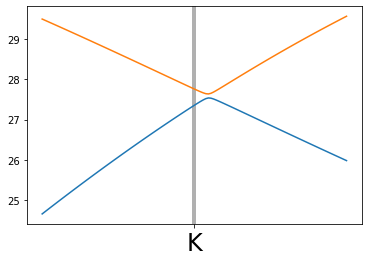

In [159]:
from matplotlib.pyplot import tick_params


plt.plot(gkascissa,gk0)
plt.plot(gkascissa,gk1)
plt.grid (b=True, axis='x')
plt.xticks([sk],['K'], size=24)
plt.tick_params(grid_linewidth=4)

In [177]:
d = np.array([[0.1,0.0,0.0],[0.0,0.1,0.0],[0.0,0.0,0.1]])
d_frac= direct.T.dot(d)
d_frac

array([[ 0.0445836,  0.       , -0.0445836],
       [-0.0257404,  0.0514807, -0.0257404],
       [ 0.0857306,  0.0857306,  0.0857306]])

In [211]:

dodline = lambda dir,branch: [bulk_disp(*(k+c*d_frac[dir]), **inp, branch=branch) for c in np.linspace(-1.0,1.0,20)]
gdx1 = dodline(dir=0,branch=0)
gdx2 = dodline(dir=0,branch=1)

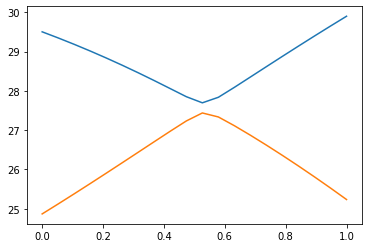

In [212]:
plt.plot(np.linspace(0,1,20), gdx2)
plt.plot(np.linspace(0,1,20), gdx1)

In [34]:
print(np.sqrt(k.dot(k)))
K = k.dot(recip)
np.pi*(np.sqrt(K.dot(K)))**2


0.4714045207910317


1.7561295500557024

In [42]:
direct[0].dot(direct[0])
np.sqrt(recip[0].dot(recip[0]))

4.0562807226633115